In [1]:
import os

real_path = "D:/sp_cup/dataset/train/real"
fake_path = "D:/sp_cup/dataset/train/fake"

real_count = len(os.listdir(real_path))
fake_count = len(os.listdir(fake_path))

print(f"Real images: {real_count}, Fake images: {fake_count}")


Real images: 42690, Fake images: 219470


### Creating a balanced dataset for training using under-sampling

In [2]:
import random
import os
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 10000  # Programmer-defined limit

# Paths to real and fake image directories
real_path = "D:/sp_cup/dataset/train/real"
fake_path = "D:/sp_cup/dataset/train/fake"

# Get the image filenames
real_images = os.listdir(real_path)
fake_images = os.listdir(fake_path)

# Apply the limit
real_images = real_images[:min(MAX_SAMPLES_PER_CLASS, len(real_images))]
fake_images = fake_images[:min(MAX_SAMPLES_PER_CLASS, len(fake_images))]

# Combine and label the dataset
balanced_dataset = [(os.path.join(real_path, img), 0) for img in real_images] + \
                   [(os.path.join(fake_path, img), 1) for img in fake_images]

# Shuffle the dataset
random.shuffle(balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(balanced_dataset)} (Real: {len(real_images)}, Fake: {len(fake_images)})")


Total dataset size: 20000 (Real: 10000, Fake: 10000)


In [4]:
print(balanced_dataset[0])

('D:/sp_cup/dataset/train/fake\\train_fake_0024908.png', 1)


In [5]:
# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
transform = transforms.Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset and DataLoader
dataset = ImageDataset(balanced_dataset, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


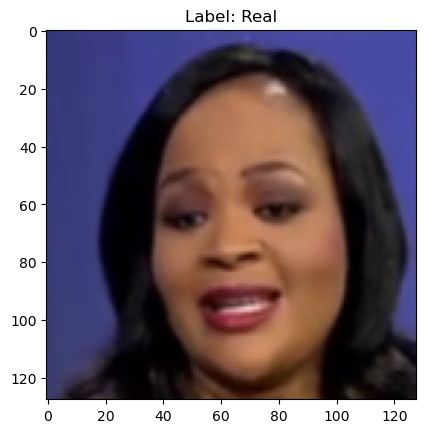

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot an image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Load the balanced dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select an image
index = 0  # Change this index to select a different image
image = images[index]
label = labels[index].item()

# Plot the image
imshow(image, title=f'Label: {"Real" if label == 0 else "Fake"}')

In [9]:
print(image.shape)

torch.Size([3, 128, 128])


In [10]:
from collections import Counter

labels = [label for _, label in balanced_dataset]
print(Counter(labels))  # Should show equal counts for both classes


Counter({1: 10000, 0: 10000})


In [11]:
import os
import sys
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from models import Model
from datasets import get_data_loaders
from train import train
from test import evaluate, load_model
import torchvision.models as models

In [9]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features  # Get the number of features from the current fc layer
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1), # Output layer for binary classification (Fake/Real)
)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
model = model.to(device)

device: cuda


In [11]:

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [40]:
# Load datasets
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
    #transforms.Normalize([0.3996, 0.3194, 0.3223], [0.2321, 0.1766, 0.1816])
    ])


train_loader = dataloader

test_dataset = datasets.ImageFolder(root='D:/sp_cup/dataset/valid', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Train dataset: {len(test_loader.dataset)} images")
print()



Train dataset: 3072 images



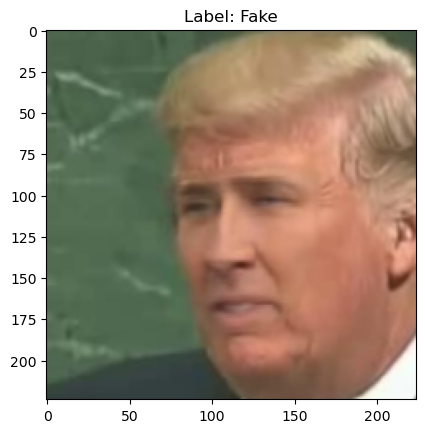

In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined your transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224 (or as required)
    transforms.ToTensor()          # Convert images to tensor
])

# Load the dataset
test_dataset = datasets.ImageFolder(root='D:/sp_cup/dataset/valid', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to convert tensor to numpy image
def imshow(img, title=None):
    img = img.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
    img = img.numpy()           # Convert to NumPy array
    plt.imshow(img)
    if title is not None:
        plt.title(title)            # Turn off axis for better visualization
    plt.show()

# Visualizing a batch of images
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get a batch of images and labels

# Display the first image in the batch
imshow(image, title=f'Label: {"Real" if label == 1 else "Fake"}')


In [13]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10
correct, total = 0, 0

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    train_loss, train_acc = 0, 0

    for batch_idx, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        X, y = X.to(device), y.float().to(device)

        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output.view(-1), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_loss += loss
        predicted = (output.view(-1) > 0.5).float()
        #accuracy.update(predicted, labels)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        torch.cuda.empty_cache()  # Clear CUDA cache to prevent memory leaks
    
    epoch_loss = train_loss / len(dataloader)
    # epoch_accuracy = accuracy.compute().item() * 100
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
        

    








  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [1/10], Batch [1/2500], Loss: 0.6839
Epoch [1/10], Batch [51/2500], Loss: 0.6890
Epoch [1/10], Batch [101/2500], Loss: 0.7639
Epoch [1/10], Batch [151/2500], Loss: 0.6093
Epoch [1/10], Batch [201/2500], Loss: 0.5617
Epoch [1/10], Batch [251/2500], Loss: 0.6909
Epoch [1/10], Batch [301/2500], Loss: 0.6753
Epoch [1/10], Batch [351/2500], Loss: 0.6088
Epoch [1/10], Batch [401/2500], Loss: 0.5283
Epoch [1/10], Batch [451/2500], Loss: 0.4676
Epoch [1/10], Batch [501/2500], Loss: 0.4906
Epoch [1/10], Batch [551/2500], Loss: 0.6240
Epoch [1/10], Batch [601/2500], Loss: 0.4959
Epoch [1/10], Batch [651/2500], Loss: 0.4289
Epoch [1/10], Batch [701/2500], Loss: 0.4415
Epoch [1/10], Batch [751/2500], Loss: 0.3511
Epoch [1/10], Batch [801/2500], Loss: 0.3515
Epoch [1/10], Batch [851/2500], Loss: 0.5080
Epoch [1/10], Batch [901/2500], Loss: 0.3641
Epoch [1/10], Batch [951/2500], Loss: 0.3915
Epoch [1/10], Batch [1001/2500], Loss: 0.4348
Epoch [1/10], Batch [1051/2500], Loss: 0.3575
Epoch [1/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [2/10], Batch [1/2500], Loss: 0.5376
Epoch [2/10], Batch [51/2500], Loss: 0.1238
Epoch [2/10], Batch [101/2500], Loss: 0.3600
Epoch [2/10], Batch [151/2500], Loss: 0.1676
Epoch [2/10], Batch [201/2500], Loss: 0.2866
Epoch [2/10], Batch [251/2500], Loss: 0.5013
Epoch [2/10], Batch [301/2500], Loss: 0.1154
Epoch [2/10], Batch [351/2500], Loss: 0.3417
Epoch [2/10], Batch [401/2500], Loss: 0.2029
Epoch [2/10], Batch [451/2500], Loss: 0.1721
Epoch [2/10], Batch [501/2500], Loss: 0.2858
Epoch [2/10], Batch [551/2500], Loss: 0.3651
Epoch [2/10], Batch [601/2500], Loss: 0.2900
Epoch [2/10], Batch [651/2500], Loss: 0.2582
Epoch [2/10], Batch [701/2500], Loss: 0.1557
Epoch [2/10], Batch [751/2500], Loss: 0.2198
Epoch [2/10], Batch [801/2500], Loss: 0.2420
Epoch [2/10], Batch [851/2500], Loss: 0.1421
Epoch [2/10], Batch [901/2500], Loss: 0.2744
Epoch [2/10], Batch [951/2500], Loss: 0.3428
Epoch [2/10], Batch [1001/2500], Loss: 0.2214
Epoch [2/10], Batch [1051/2500], Loss: 0.3306
Epoch [2/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [3/10], Batch [1/2500], Loss: 0.1104
Epoch [3/10], Batch [51/2500], Loss: 0.3626
Epoch [3/10], Batch [101/2500], Loss: 0.1834
Epoch [3/10], Batch [151/2500], Loss: 0.2846
Epoch [3/10], Batch [201/2500], Loss: 0.2608
Epoch [3/10], Batch [251/2500], Loss: 0.0978
Epoch [3/10], Batch [301/2500], Loss: 0.0399
Epoch [3/10], Batch [351/2500], Loss: 0.1874
Epoch [3/10], Batch [401/2500], Loss: 0.2481
Epoch [3/10], Batch [451/2500], Loss: 0.3325
Epoch [3/10], Batch [501/2500], Loss: 0.1415
Epoch [3/10], Batch [551/2500], Loss: 0.2246
Epoch [3/10], Batch [601/2500], Loss: 0.2158
Epoch [3/10], Batch [651/2500], Loss: 0.1534
Epoch [3/10], Batch [701/2500], Loss: 0.1400
Epoch [3/10], Batch [751/2500], Loss: 0.3545
Epoch [3/10], Batch [801/2500], Loss: 0.1224
Epoch [3/10], Batch [851/2500], Loss: 0.4562
Epoch [3/10], Batch [901/2500], Loss: 0.0718
Epoch [3/10], Batch [951/2500], Loss: 0.2434
Epoch [3/10], Batch [1001/2500], Loss: 0.2602
Epoch [3/10], Batch [1051/2500], Loss: 0.0510
Epoch [3/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [4/10], Batch [1/2500], Loss: 0.1235
Epoch [4/10], Batch [51/2500], Loss: 0.0364
Epoch [4/10], Batch [101/2500], Loss: 0.3149
Epoch [4/10], Batch [151/2500], Loss: 0.0770
Epoch [4/10], Batch [201/2500], Loss: 0.1214
Epoch [4/10], Batch [251/2500], Loss: 0.2255
Epoch [4/10], Batch [301/2500], Loss: 0.1652
Epoch [4/10], Batch [351/2500], Loss: 0.0281
Epoch [4/10], Batch [401/2500], Loss: 0.1583
Epoch [4/10], Batch [451/2500], Loss: 0.2217
Epoch [4/10], Batch [501/2500], Loss: 0.0760
Epoch [4/10], Batch [551/2500], Loss: 0.0929
Epoch [4/10], Batch [601/2500], Loss: 0.1248
Epoch [4/10], Batch [651/2500], Loss: 0.1049
Epoch [4/10], Batch [701/2500], Loss: 0.0552
Epoch [4/10], Batch [751/2500], Loss: 0.0543
Epoch [4/10], Batch [801/2500], Loss: 0.3472
Epoch [4/10], Batch [851/2500], Loss: 0.0622
Epoch [4/10], Batch [901/2500], Loss: 0.0664
Epoch [4/10], Batch [951/2500], Loss: 0.2293
Epoch [4/10], Batch [1001/2500], Loss: 0.4983
Epoch [4/10], Batch [1051/2500], Loss: 0.1422
Epoch [4/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [5/10], Batch [1/2500], Loss: 0.1015
Epoch [5/10], Batch [51/2500], Loss: 0.0519
Epoch [5/10], Batch [101/2500], Loss: 0.3440
Epoch [5/10], Batch [151/2500], Loss: 0.1448
Epoch [5/10], Batch [201/2500], Loss: 0.0543
Epoch [5/10], Batch [251/2500], Loss: 0.1793
Epoch [5/10], Batch [301/2500], Loss: 0.2037
Epoch [5/10], Batch [351/2500], Loss: 0.0741
Epoch [5/10], Batch [401/2500], Loss: 0.0959
Epoch [5/10], Batch [451/2500], Loss: 0.0710
Epoch [5/10], Batch [501/2500], Loss: 0.2473
Epoch [5/10], Batch [551/2500], Loss: 0.0626
Epoch [5/10], Batch [601/2500], Loss: 0.0696
Epoch [5/10], Batch [651/2500], Loss: 0.1519
Epoch [5/10], Batch [701/2500], Loss: 0.1299
Epoch [5/10], Batch [751/2500], Loss: 0.0554
Epoch [5/10], Batch [801/2500], Loss: 0.1106
Epoch [5/10], Batch [851/2500], Loss: 0.0472
Epoch [5/10], Batch [901/2500], Loss: 0.1332
Epoch [5/10], Batch [951/2500], Loss: 0.1455
Epoch [5/10], Batch [1001/2500], Loss: 0.1140
Epoch [5/10], Batch [1051/2500], Loss: 0.1553
Epoch [5/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [6/10], Batch [1/2500], Loss: 0.0329
Epoch [6/10], Batch [51/2500], Loss: 0.1497
Epoch [6/10], Batch [101/2500], Loss: 0.0365
Epoch [6/10], Batch [151/2500], Loss: 0.1022
Epoch [6/10], Batch [201/2500], Loss: 0.0315
Epoch [6/10], Batch [251/2500], Loss: 0.0441
Epoch [6/10], Batch [301/2500], Loss: 0.1364
Epoch [6/10], Batch [351/2500], Loss: 0.0631
Epoch [6/10], Batch [401/2500], Loss: 0.0823
Epoch [6/10], Batch [451/2500], Loss: 0.0798
Epoch [6/10], Batch [501/2500], Loss: 0.1899
Epoch [6/10], Batch [551/2500], Loss: 0.6518
Epoch [6/10], Batch [601/2500], Loss: 0.5964
Epoch [6/10], Batch [651/2500], Loss: 0.5000
Epoch [6/10], Batch [701/2500], Loss: 0.3687
Epoch [6/10], Batch [751/2500], Loss: 0.3664
Epoch [6/10], Batch [801/2500], Loss: 0.1707
Epoch [6/10], Batch [851/2500], Loss: 0.3561
Epoch [6/10], Batch [901/2500], Loss: 0.2968
Epoch [6/10], Batch [951/2500], Loss: 0.4127
Epoch [6/10], Batch [1001/2500], Loss: 0.0712
Epoch [6/10], Batch [1051/2500], Loss: 0.2338
Epoch [6/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [7/10], Batch [1/2500], Loss: 0.0698
Epoch [7/10], Batch [51/2500], Loss: 0.2694
Epoch [7/10], Batch [101/2500], Loss: 0.1970
Epoch [7/10], Batch [151/2500], Loss: 0.0272
Epoch [7/10], Batch [201/2500], Loss: 0.0170
Epoch [7/10], Batch [251/2500], Loss: 0.1130
Epoch [7/10], Batch [301/2500], Loss: 0.0972
Epoch [7/10], Batch [351/2500], Loss: 0.0906
Epoch [7/10], Batch [401/2500], Loss: 0.0656
Epoch [7/10], Batch [451/2500], Loss: 0.1340
Epoch [7/10], Batch [501/2500], Loss: 0.0187
Epoch [7/10], Batch [551/2500], Loss: 0.0315
Epoch [7/10], Batch [601/2500], Loss: 0.2858
Epoch [7/10], Batch [651/2500], Loss: 0.1976
Epoch [7/10], Batch [701/2500], Loss: 0.1478
Epoch [7/10], Batch [751/2500], Loss: 0.0598
Epoch [7/10], Batch [801/2500], Loss: 0.1787
Epoch [7/10], Batch [851/2500], Loss: 0.0849
Epoch [7/10], Batch [901/2500], Loss: 0.0773
Epoch [7/10], Batch [951/2500], Loss: 0.0907
Epoch [7/10], Batch [1001/2500], Loss: 0.1950
Epoch [7/10], Batch [1051/2500], Loss: 0.1214
Epoch [7/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [8/10], Batch [1/2500], Loss: 0.0921
Epoch [8/10], Batch [51/2500], Loss: 0.0102
Epoch [8/10], Batch [101/2500], Loss: 0.0204
Epoch [8/10], Batch [151/2500], Loss: 0.0066
Epoch [8/10], Batch [201/2500], Loss: 0.0493
Epoch [8/10], Batch [251/2500], Loss: 0.0698
Epoch [8/10], Batch [301/2500], Loss: 0.1040
Epoch [8/10], Batch [351/2500], Loss: 0.0083
Epoch [8/10], Batch [401/2500], Loss: 0.0400
Epoch [8/10], Batch [451/2500], Loss: 0.1469
Epoch [8/10], Batch [501/2500], Loss: 0.1737
Epoch [8/10], Batch [551/2500], Loss: 0.0659
Epoch [8/10], Batch [601/2500], Loss: 0.0816
Epoch [8/10], Batch [651/2500], Loss: 0.0245
Epoch [8/10], Batch [701/2500], Loss: 0.1830
Epoch [8/10], Batch [751/2500], Loss: 0.0664
Epoch [8/10], Batch [801/2500], Loss: 0.0712
Epoch [8/10], Batch [851/2500], Loss: 0.3522
Epoch [8/10], Batch [901/2500], Loss: 0.1517
Epoch [8/10], Batch [951/2500], Loss: 0.0140
Epoch [8/10], Batch [1001/2500], Loss: 0.1116
Epoch [8/10], Batch [1051/2500], Loss: 0.1170
Epoch [8/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [9/10], Batch [1/2500], Loss: 0.0745
Epoch [9/10], Batch [51/2500], Loss: 0.0751
Epoch [9/10], Batch [101/2500], Loss: 0.0188
Epoch [9/10], Batch [151/2500], Loss: 0.0349
Epoch [9/10], Batch [201/2500], Loss: 0.0443
Epoch [9/10], Batch [251/2500], Loss: 0.3004
Epoch [9/10], Batch [301/2500], Loss: 0.0215
Epoch [9/10], Batch [351/2500], Loss: 0.0329
Epoch [9/10], Batch [401/2500], Loss: 0.2008
Epoch [9/10], Batch [451/2500], Loss: 0.0404
Epoch [9/10], Batch [501/2500], Loss: 0.1197
Epoch [9/10], Batch [551/2500], Loss: 0.0416
Epoch [9/10], Batch [601/2500], Loss: 0.0376
Epoch [9/10], Batch [651/2500], Loss: 0.0300
Epoch [9/10], Batch [701/2500], Loss: 0.0369
Epoch [9/10], Batch [751/2500], Loss: 0.0043
Epoch [9/10], Batch [801/2500], Loss: 0.0874
Epoch [9/10], Batch [851/2500], Loss: 0.0709
Epoch [9/10], Batch [901/2500], Loss: 0.3406
Epoch [9/10], Batch [951/2500], Loss: 0.0220
Epoch [9/10], Batch [1001/2500], Loss: 0.0468
Epoch [9/10], Batch [1051/2500], Loss: 0.0755
Epoch [9/10

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch [10/10], Batch [1/2500], Loss: 0.0908
Epoch [10/10], Batch [51/2500], Loss: 0.0351
Epoch [10/10], Batch [101/2500], Loss: 0.0204
Epoch [10/10], Batch [151/2500], Loss: 0.0187
Epoch [10/10], Batch [201/2500], Loss: 0.0106
Epoch [10/10], Batch [251/2500], Loss: 0.0946
Epoch [10/10], Batch [301/2500], Loss: 0.0621
Epoch [10/10], Batch [351/2500], Loss: 0.4452
Epoch [10/10], Batch [401/2500], Loss: 0.0857
Epoch [10/10], Batch [451/2500], Loss: 0.0491
Epoch [10/10], Batch [501/2500], Loss: 0.0374
Epoch [10/10], Batch [551/2500], Loss: 0.2401
Epoch [10/10], Batch [601/2500], Loss: 0.0401
Epoch [10/10], Batch [651/2500], Loss: 0.1030
Epoch [10/10], Batch [701/2500], Loss: 0.0160
Epoch [10/10], Batch [751/2500], Loss: 0.0677
Epoch [10/10], Batch [801/2500], Loss: 0.0355
Epoch [10/10], Batch [851/2500], Loss: 0.1612
Epoch [10/10], Batch [901/2500], Loss: 0.0411
Epoch [10/10], Batch [951/2500], Loss: 0.0485
Epoch [10/10], Batch [1001/2500], Loss: 0.0116
Epoch [10/10], Batch [1051/2500], Lo

In [46]:
# Save final model
from pathlib import Path

MODEL_PATH = Path("test_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_01_resnet50.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

Saving model to: test_models\model_01_resnet50.pth


In [16]:
next(model.parameters()).device

device(type='cuda', index=0)

In [47]:
loaded_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the fully connected layer to match the saved model
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Sequential(
	nn.Linear(num_features, 512),
	nn.ReLU(),
	nn.Dropout(0.5),
	nn.Linear(512, 1),
	nn.Sigmoid()
)

MODEL_SAVE_PATH = 'test_models/model_01_resnet50.pth'
state_dict = torch.load(MODEL_SAVE_PATH)

loaded_model.load_state_dict(state_dict)
loaded_model = loaded_model.to(device)
print(f"Model loaded from {MODEL_SAVE_PATH}")

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_26840\811438051.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH)


Model loaded from test_models/model_01_resnet50.pth


In [48]:
from sklearn.metrics import confusion_matrix
model = loaded_model

loss, acc = 0,0 
model.eval()
correct, total = 0, 0
all_labels = []
all_predictions = []

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.float().to(device)
        output = model(X)
        loss += criterion(output.view(-1), y).item()
        predicted = (output.view(-1) > 0.5).float()
        acc += (predicted == y).sum().item()

        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    loss /= len(test_loader)
    acc = 100 * acc / len(test_loader.dataset)

print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Accuracy of the model on the validation images: {acc:.2f}%')
print(f'True Negatives (Real identified as Real): {tn}')
print(f'False Positives (Real identified as Fake): {fp}')
print(f'False Negatives (Fake identified as Real): {fn}')
print(f'True Positives (Fake identified as Fake): {tp}')
print('Confusion Matrix:')
print(conf_matrix)

Test Loss: 0.8508, Test Accuracy: 36.49%
Accuracy of the model on the validation images: 36.49%
True Negatives (Real identified as Real): 42
False Positives (Real identified as Fake): 1482
False Negatives (Fake identified as Real): 469
True Positives (Fake identified as Fake): 1079
Confusion Matrix:
[[  42 1482]
 [ 469 1079]]


In [20]:
from sklearn.metrics import confusion_matrix

loss, acc = 0,0 
model.eval()
correct, total = 0, 0
all_labels = []
all_predictions = []

with torch.inference_mode():
    for X, y in train_loader:
        X, y = X.to(device), y.float().to(device)
        output = model(X)
        loss += criterion(output.view(-1), y).item()
        predicted = (output.view(-1) > 0.5).float()
        acc += (predicted == y).sum().item()

        all_labels.extend(y.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    loss /= len(train_loader)
    acc = 100 * acc / len(train_loader.dataset)

print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_predictions)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Accuracy of the model on the validation images: {acc:.2f}%')
print(f'True Negatives (Real identified as Real): {tn}')
print(f'False Positives (Real identified as Fake): {fp}')
print(f'False Negatives (Fake identified as Real): {fn}')
print(f'True Positives (Fake identified as Fake): {tp}')
print('Confusion Matrix:')
print(conf_matrix)

Test Loss: 0.0495, Test Accuracy: 98.19%
Accuracy of the model on the validation images: 98.19%
True Negatives (Real identified as Real): 39237
False Positives (Real identified as Fake): 763
False Negatives (Fake identified as Real): 682
True Positives (Fake identified as Fake): 39318
Confusion Matrix:
[[39237   763]
 [  682 39318]]
